0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:


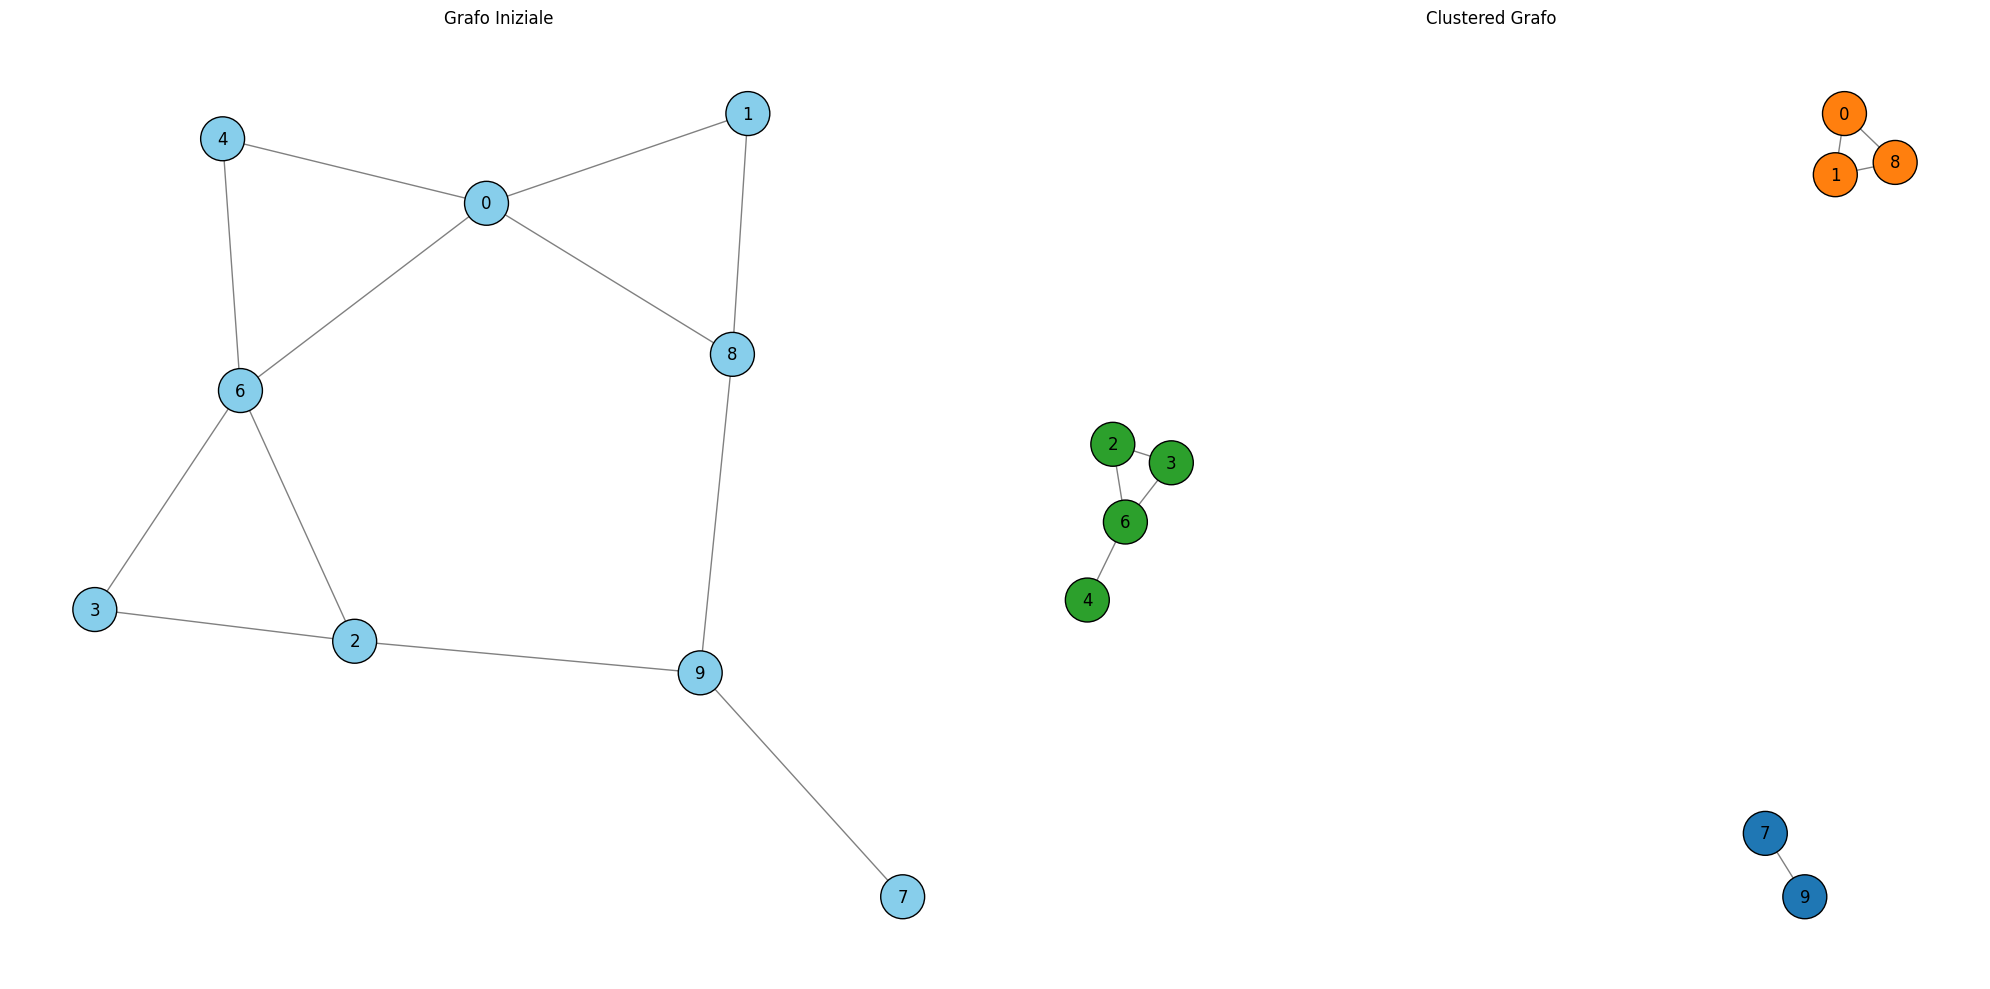

Tempo di esecuzione dell'algoritmo di Louvain: 0.00040221214294433594 secondi.


In [130]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

""" def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)
    return clusters """
    
def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)

    # Aggiungo l'assegnazione delle etichette dei cluster ai nodi
    for cluster_index, cluster in enumerate(clusters):
        for node in cluster:
            graph.nodes[node]['cluster'] = cluster_index

    # Elimino i bordi tra i cluster e li conto
    edge_count = 0
    edges_to_remove = []
    for edge in graph.edges:
        if graph.nodes[edge[0]]['cluster'] != graph.nodes[edge[1]]['cluster']:
            edge_count += 1
            edges_to_remove.append(edge)
    graph.remove_edges_from(edges_to_remove)

    return clusters, edge_count

if __name__ == "__main__":
    grafo = Graph()
    for i in range(10):
        grafo.aggiungi_vertice(i)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)
    
    grafo.rimuovi_vertice(5)
    
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    # clusters = divide_into_clusters(G_initial, k)
    clusters, edge_count = divide_into_clusters(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")

### Senza  l'algoritmo di clustering di Louvain.

#### Utilizzo di un algoritmo gerarchico

Questo algoritmo inizia assegnando ciascun nodo al suo cluster e poi, ad ogni passo, fonde i due cluster più vicini fino a quando non rimangono solo k cluster. La "vicinanza" tra due cluster può essere definita in vari modi; in questo esempio, useremo la distanza minima tra i nodi di due cluster differenti.

0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:


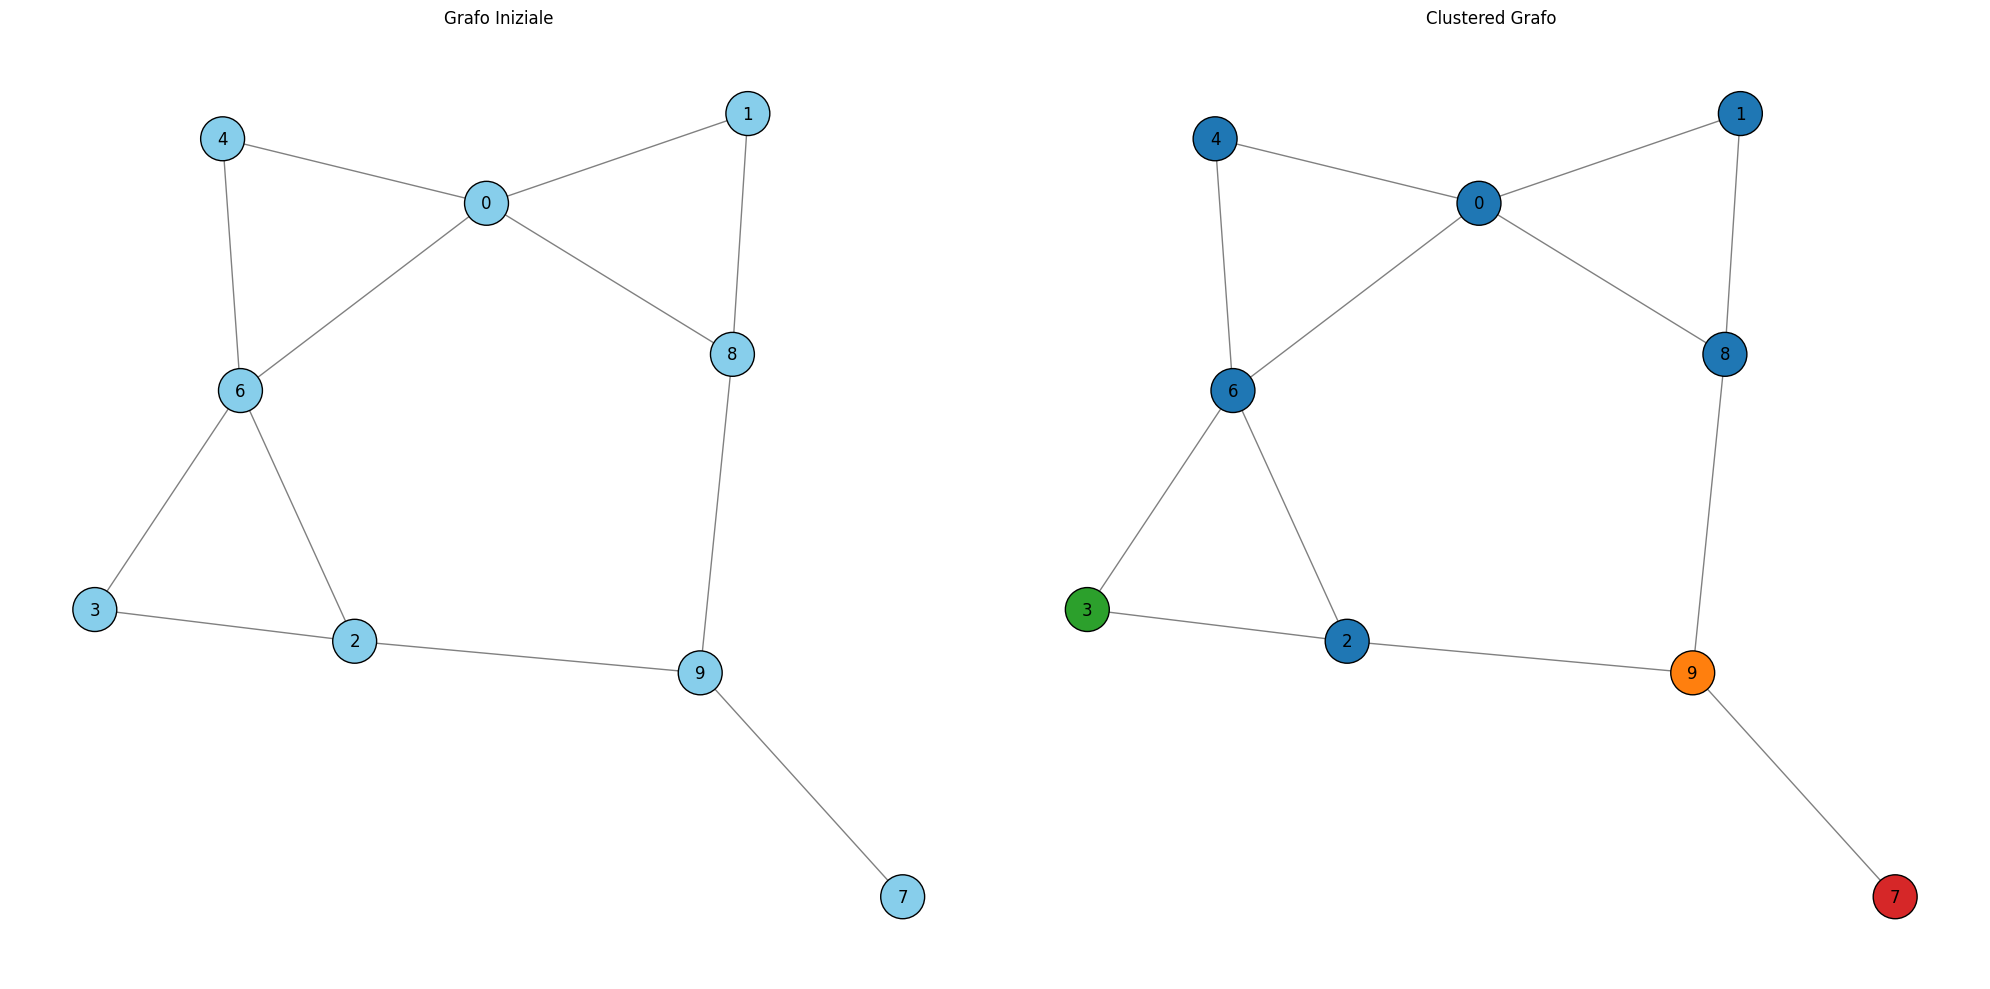

Tempo di esecuzione dell'algoritmo di clustering gerarchico: 0.0005652904510498047 secondi.


In [131]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import time

def plot_graph(graph, title, subplot, colors=None):
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}

    node_colors = {node: 'skyblue' for node in graph.nodes()}
    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    plt.subplot(subplot)
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)
    plt.title(title)

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u) 

    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

""" def distance(u, v):
    if v in G_initial[u]:
        return 1 / len(G_initial[u])
    else:
        return float('inf') """
def distance(u, v):
    try:
        return nx.shortest_path_length(G_initial, u, v)
    except nx.NetworkXNoPath:
        return float('inf')


def cluster_distance(cluster1, cluster2):
    return min(distance(u, v) for u in cluster1 for v in cluster2)

def find_closest_clusters(clusters):
    min_distance = float('inf')
    closest_clusters = None
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = cluster_distance(clusters[i], clusters[j])
            if dist < min_distance:
                min_distance = dist
                closest_clusters = (i, j)
    return closest_clusters

def hierarchical_clustering(graph, k):
    clusters = [[node] for node in graph.nodes()]

    while len(clusters) > k:
        i, j = find_closest_clusters(clusters)
        clusters[i] += clusters[j]
        del clusters[j]

    return clusters

if __name__ == "__main__":
    grafo = Graph()

    grafo.aggiungi_vertice(0)
    grafo.aggiungi_vertice(1)
    grafo.aggiungi_vertice(2)
    grafo.aggiungi_vertice(3)
    grafo.aggiungi_vertice(4)
    grafo.aggiungi_vertice(6)
    grafo.aggiungi_vertice(7)
    grafo.aggiungi_vertice(8)
    grafo.aggiungi_vertice(9)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)

    grafo.stampa_grafo()

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)

    plt.figure(figsize=(20, 10))  # Dimensioni della figura
    
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", 121)  # Primo subplot 

    k = 4
    start_time = time.time()
    clusters = hierarchical_clustering(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)  # Secondo subplot 

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di clustering gerarchico: {elapsed_time} secondi.")